## <center> Use of Facial Recognition and ECG Values to Improve the Efficiency of Health Monitoring System in Vehicles </center>
### <center> Vikesh Singh and Pranay Bhal

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

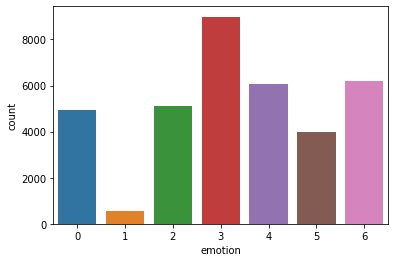

In [7]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [8]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

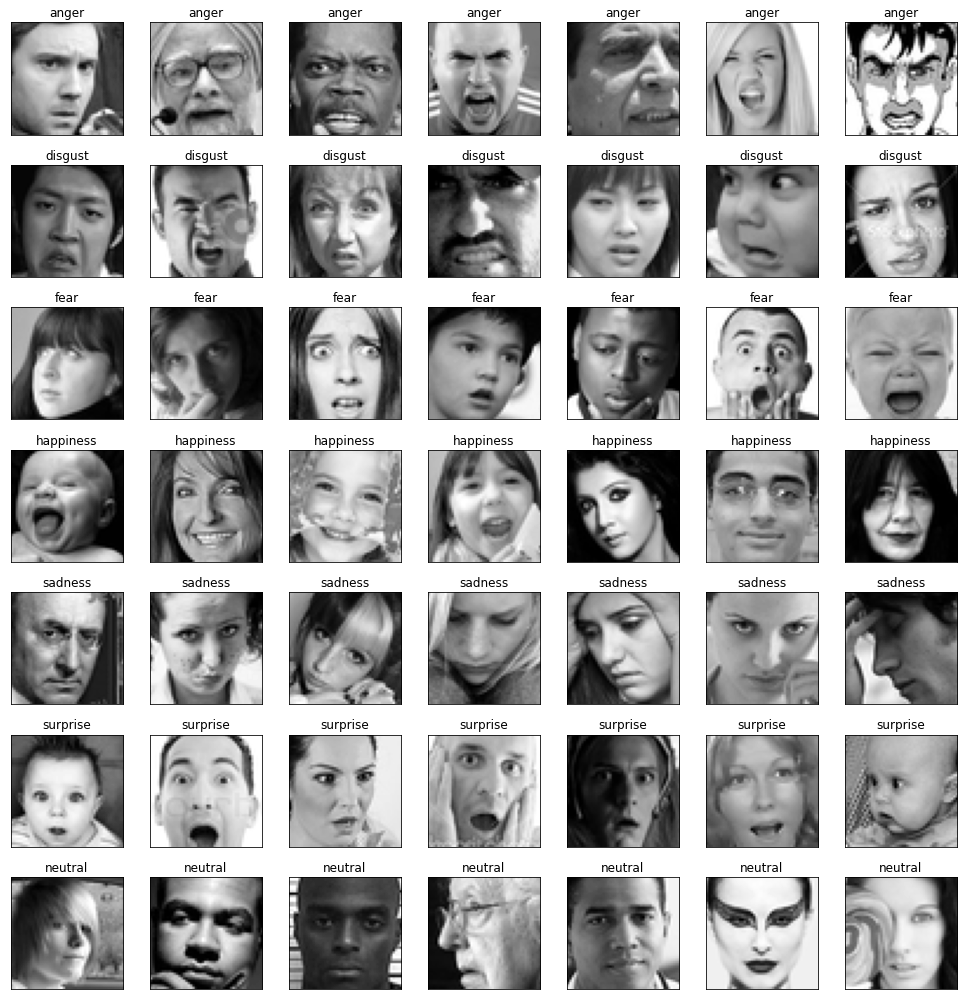

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [10]:
INTERESTED_LABELS = [3, 4, 6]

In [11]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

`Making the data compatible for neural networks.`

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [13]:
img_array.shape

(21264, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [15]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


`Splitting the data into training and validation set.`

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [17]:
del df
del img_array
del img_labels

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [19]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [20]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [21]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [22]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [23]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

In [24]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

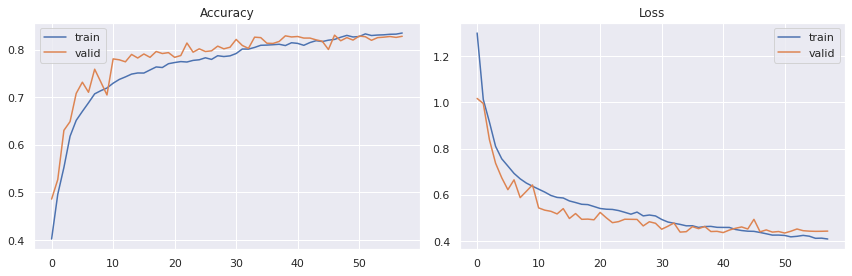

In [30]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

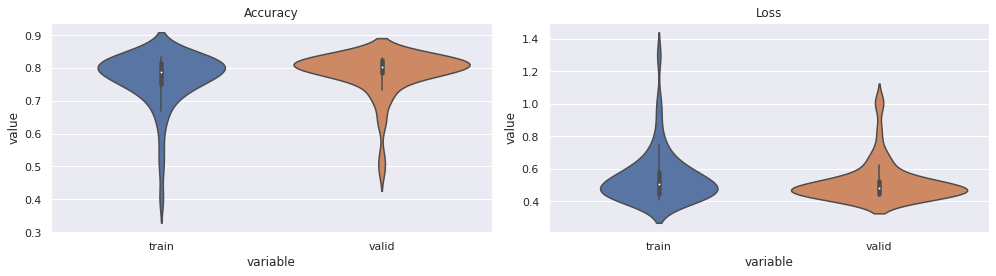

In [26]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

total wrong validation predictions: 361


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       899
           1       0.82      0.71      0.76       608
           2       0.72      0.80      0.76       620

    accuracy                           0.83      2127
   macro avg       0.82      0.81      0.82      2127
weighted avg       0.83      0.83      0.83      2127



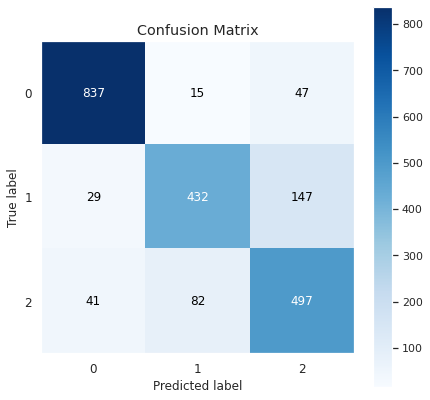

In [31]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [28]:
mapper = {
    0: "excited",
    1: "tensed",
    2: "neutral",
}

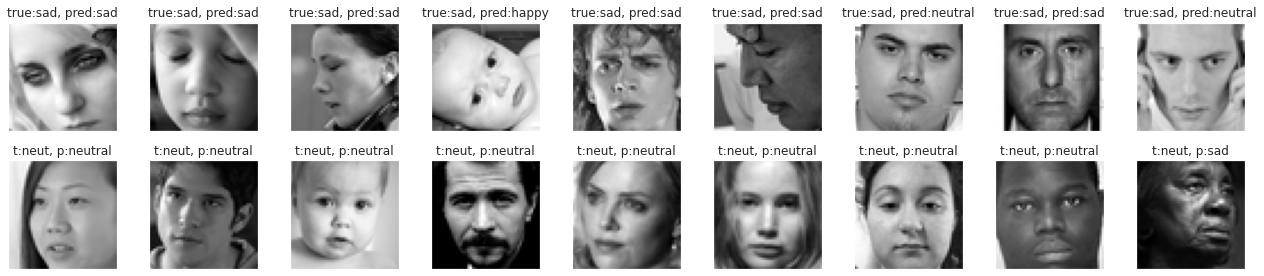

In [29]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.

`We we will now map our previous heart rate rr derivative values with the emotion constructs that our faces are able to provide`

### Imports

In [ ]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

### Settings

In [ ]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500

### Load data

In [ ]:
# data recorded with the ECG sensor
df = pd.read_csv("/ecg.csv", sep=";", index_col="ms")

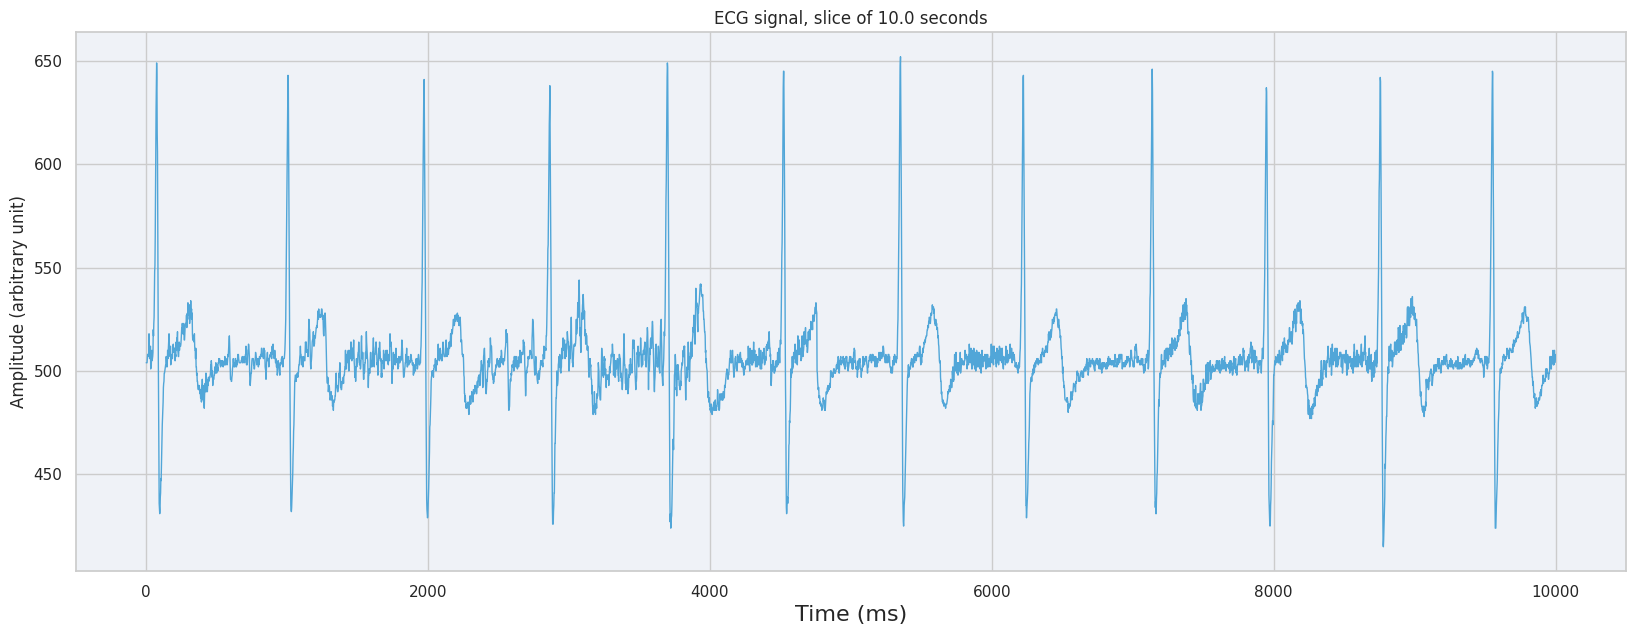

In [ ]:
plt.figure(figsize=(20, 7))
start = 0
stop = 5000
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

This seems like a clean ECG signal and I suppose finding peaks won’t be much of a problem. This ECG sensor returns values as a [arbitrary units](https://en.wikipedia.org/wiki/Arbitrary_unit), so these are not real voltages. We should take just interest in the relative values. 

Let’s find out how we can find the peaks.

### Peak detection using template matching

*There are a [myriad](https://scholar.google.nl/scholar?as_sdt=1,5&q=peak+detection+ECG&hl=nl&as_ylo=2018) of different QRS detectors. Most of those consists of two stages:*

* **Stage 1 — Signal transformation
**Construct a signal that maximises the features of interest, in our case this is the QRS-complex.

* **Stage 2 — Decision rule 
**Use a threshold to separate the desired features from the rest of the signal

A lot of peak detectors use a very neat trick for transforming the signal (stage 1) and I found it worth diving into that. It’s called [template matching](https://en.wikipedia.org/wiki/Template_matching).

Template matching is widely used in pattern recognition, for example in [particle analysis](https://www.ncbi.nlm.nih.gov/pubmed/15065671), cryptanalysis, [computer vision](https://www.researchgate.net/publication/272496016_Template_Matching_Techniques_in_Computer_Vision_Theory_and_Practice) and [computational neuroscience](https://www.hindawi.com/journals/cin/2014/919406/). It’s an elegant and powerful technique that uses a filter (also known as template or kernel), that contains a **specific feature** and use that filter to find this feature in a larger signal.

![Cross-correlation is a measure of the similarity between two signals (image taken from [Giphy](https://media.giphy.com/media/VVPKOXc6aY1Lq/source.gif))](https://cdn-images-1.medium.com/max/2000/1*mWsGTGVdAsy6KoF3n3MyLA.gif)

Basic idea is to slide the filter along a signal and compute the [cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation) between the filter and the signal. If the filter matches a part of the signal closely, there is a strong correlation, which is another way of saying this part of the signal looks a lot like the feature in the filter. By setting a threshold (stage 2), you are able to find features you’re interested in.
>  Cross-correlation is often referred to as **convolution**, which is a slightly different operation where the filter is reversed f(t) -› f(-t) before sliding it along the signal. Convolutional Neural Networks should actually be named Cross-correlation Networks, but i guess that didn’t make it through the marketing department :-)

In images you could use this technique to find horizontal or vertical edges by designing specific filters. Convolutional Networks take this approach even further and learn filters that are relevant for certain classes automatically using back propagation.

*Allright, so template matching seems great. Lets see how we can use it to find some RR-intervals!*

In [ ]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

In [ ]:
def get_plot_ranges(start=10, end=20, n=5):
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

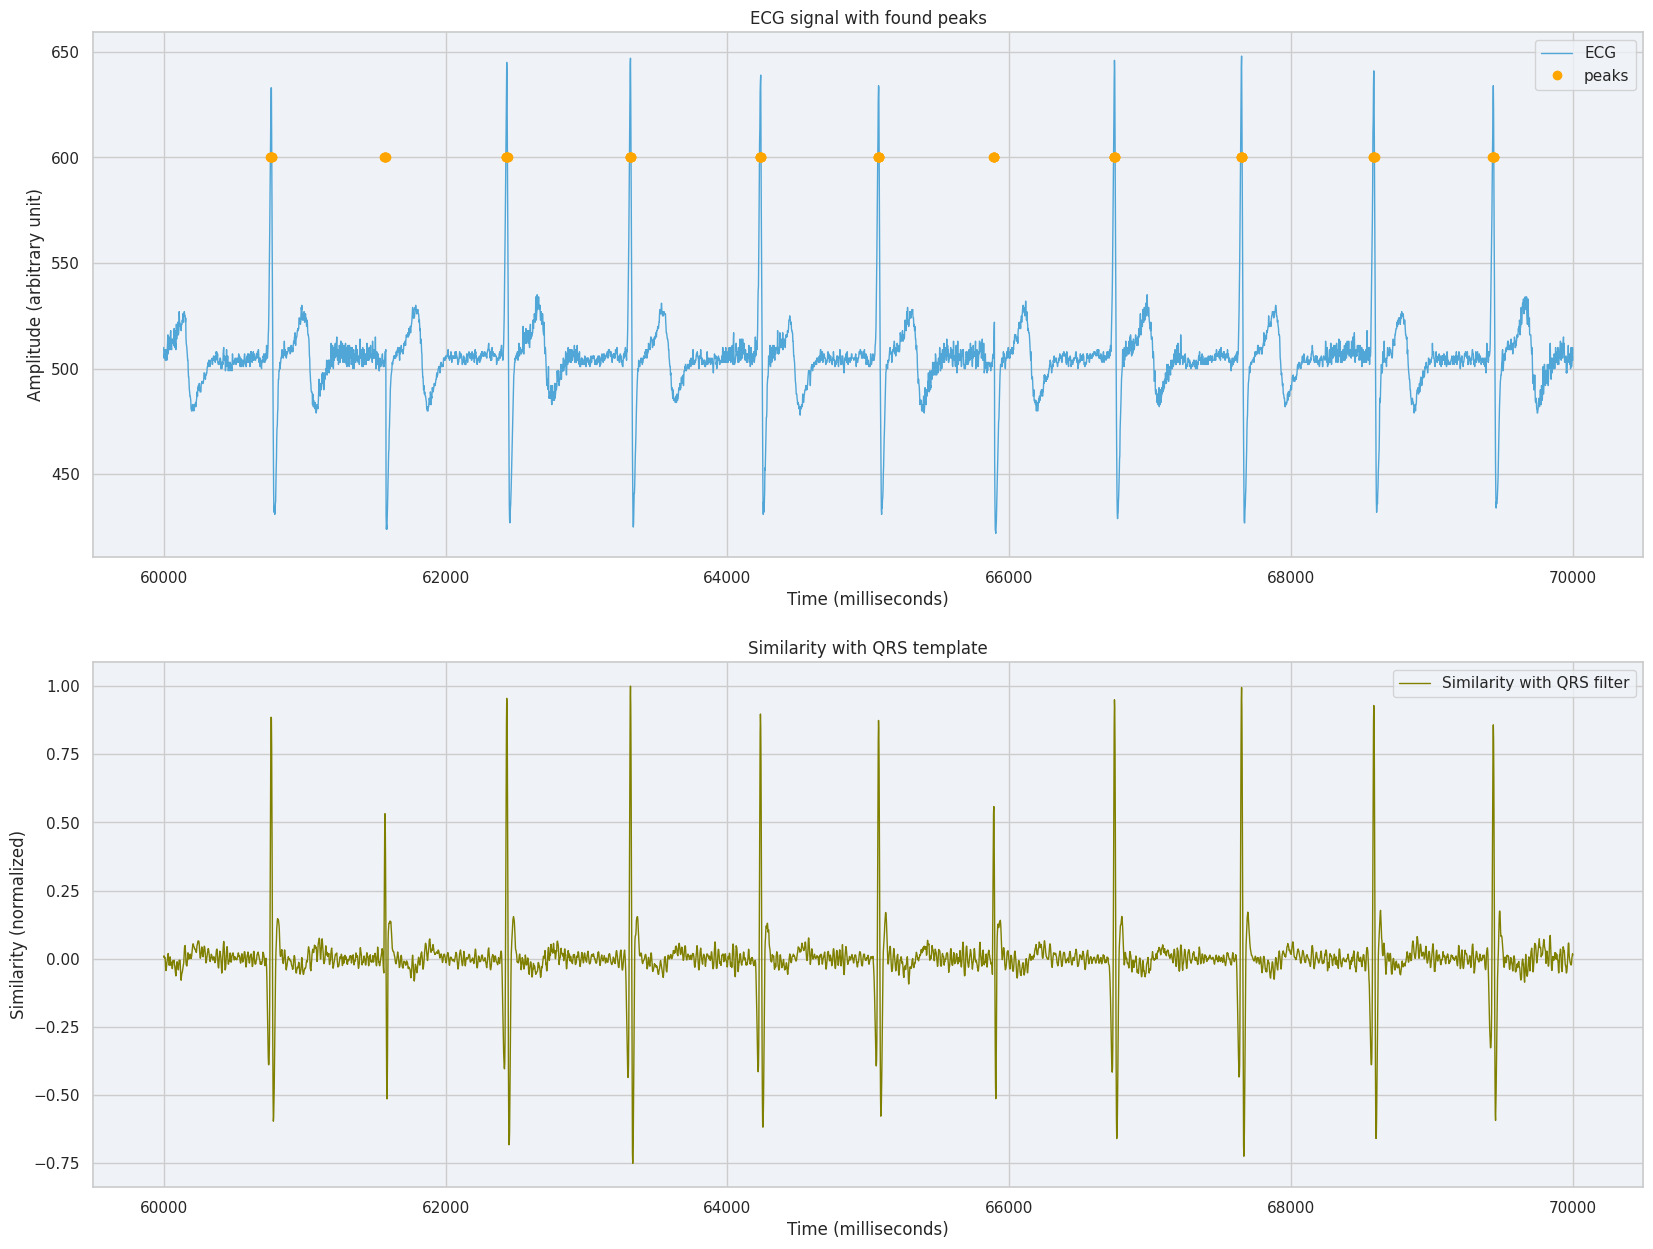

In [ ]:
sampfrom = 60000
sampto = 70000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop) 
    ecg_slice = df.heartrate[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(600, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    

### Group similar peaks

When using thresholding to extract the peaks, there are still multiple samples found for a single peak. To get single a value for each peak, I'll group the samples that are very near.

In [ ]:
def group_peaks(p, threshold=5):
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

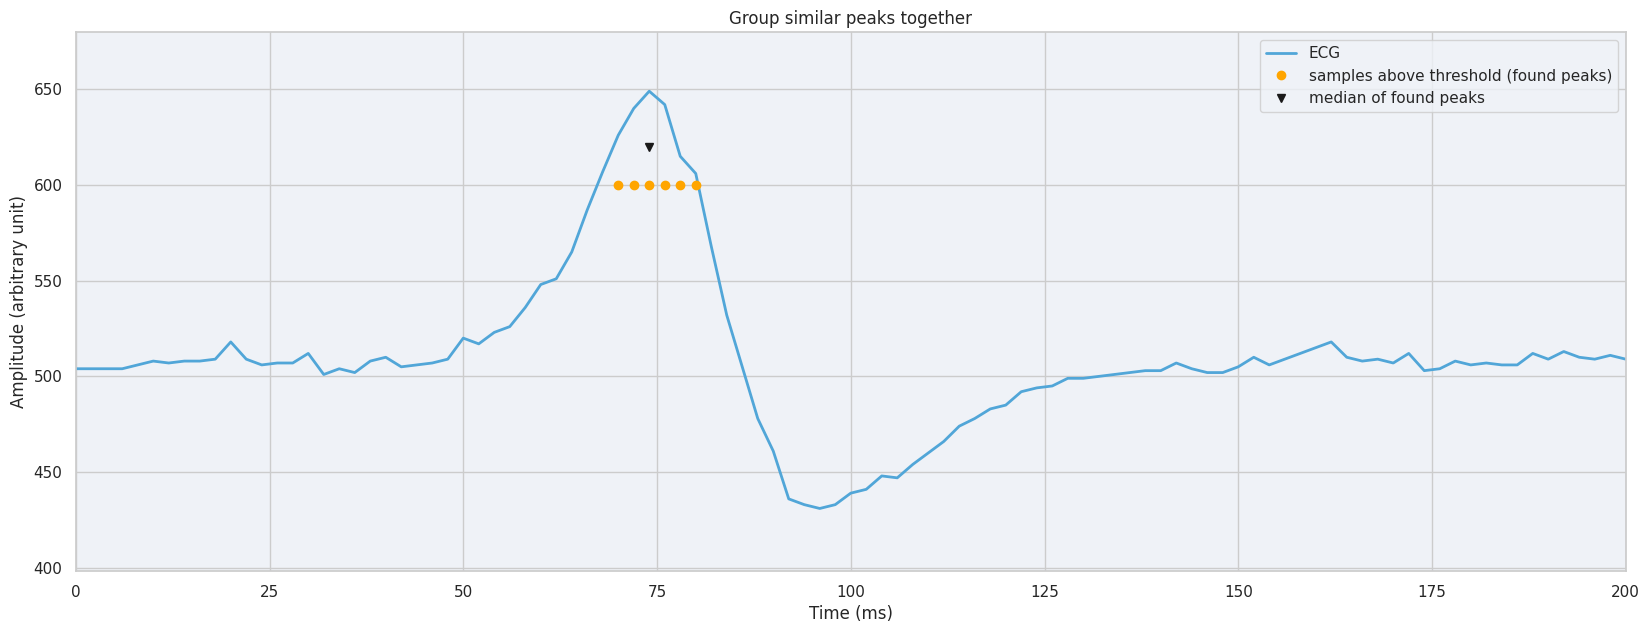

In [ ]:
# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(600, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(620, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()

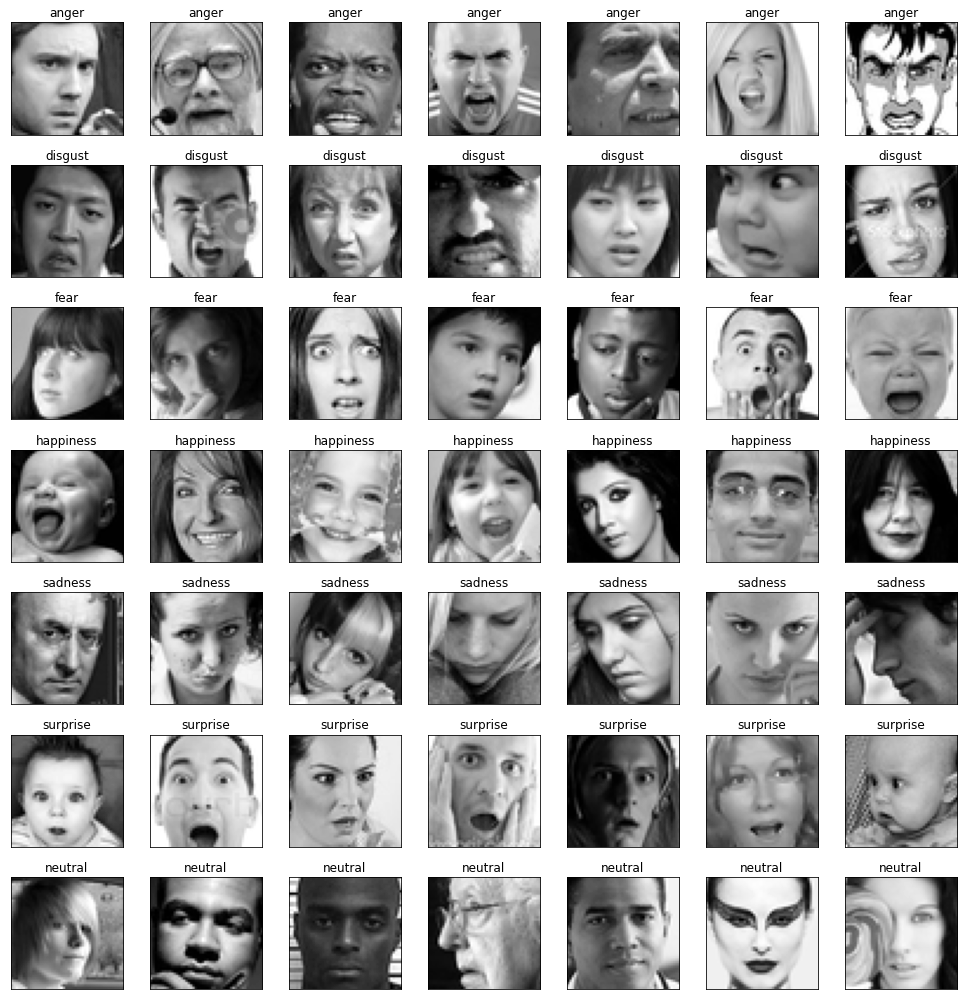

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

### Error correction

If there is only a small amount of errors, we can correct them. There are different ways to correct the errors, and as a first attempt I replaced the outliers with the median value of the RR-intervals. For this, I use the [zscore](https://nl.wikipedia.org/wiki/Z-score), which is a metric for the **distance between a value and the mean of a distribution**, measured in standard deviations. By selecting RR-intervals with an absolute zscore larger than 2, we find the outliers and we can correct these by setting it to the median value.


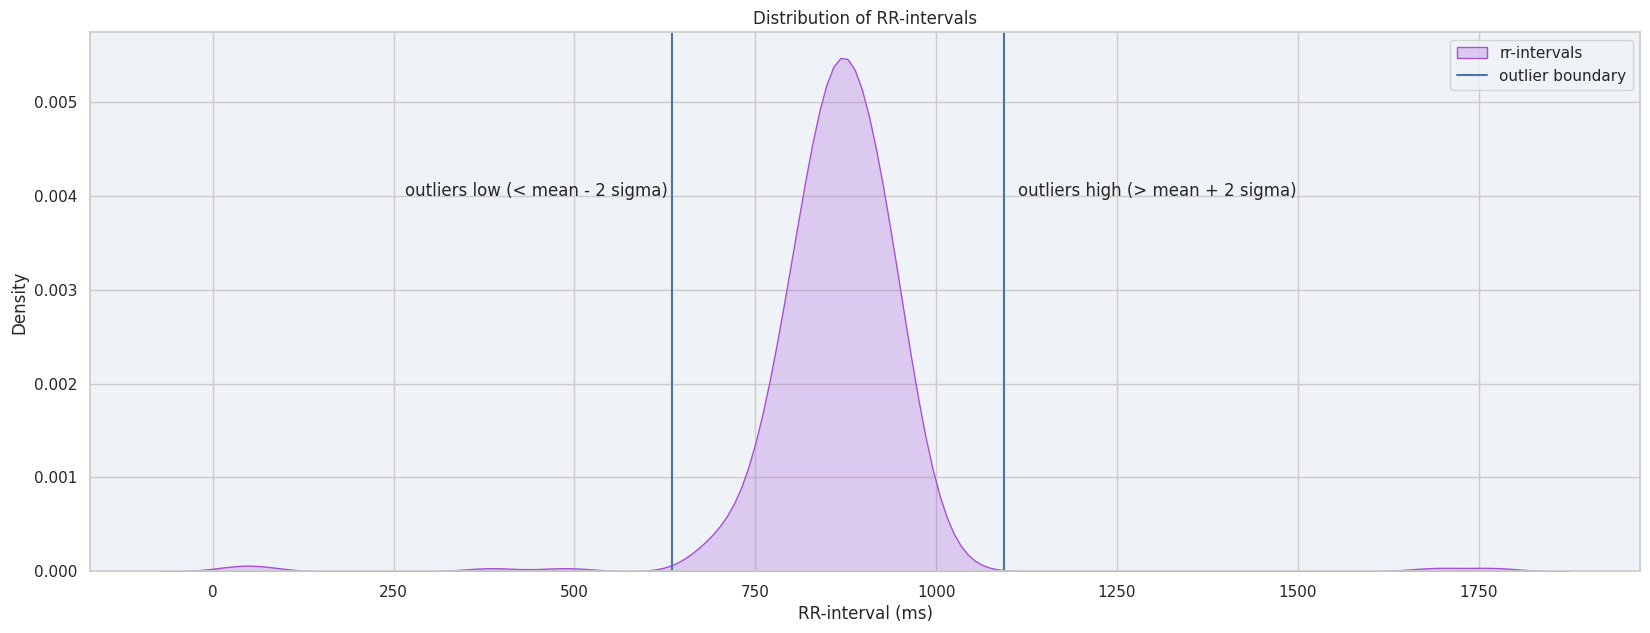

In [ ]:
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr) - 2 * np.std(rr)
outlier_high = np.mean(rr) + 2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

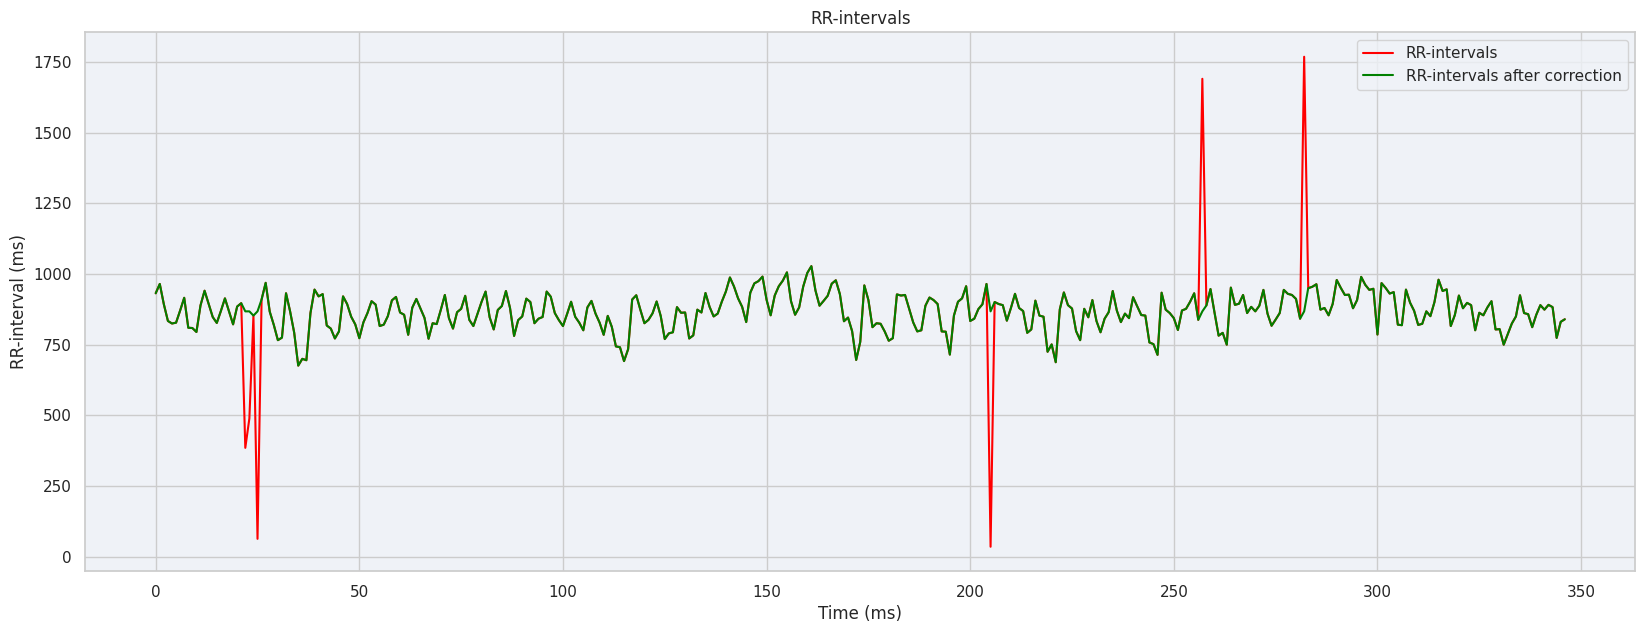

In [ ]:
plt.figure(figsize=(20, 7))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

Downside of this approach is that the timings are no longer precise. For anl HRV analysis, this doesn’t have to be a big issue, but because I want to plot the RR-intervals on top of the ECG data, the alignment needs to be exact. Therefore, I corrected the errors manually as well.

### Plot ECG signal with intervals

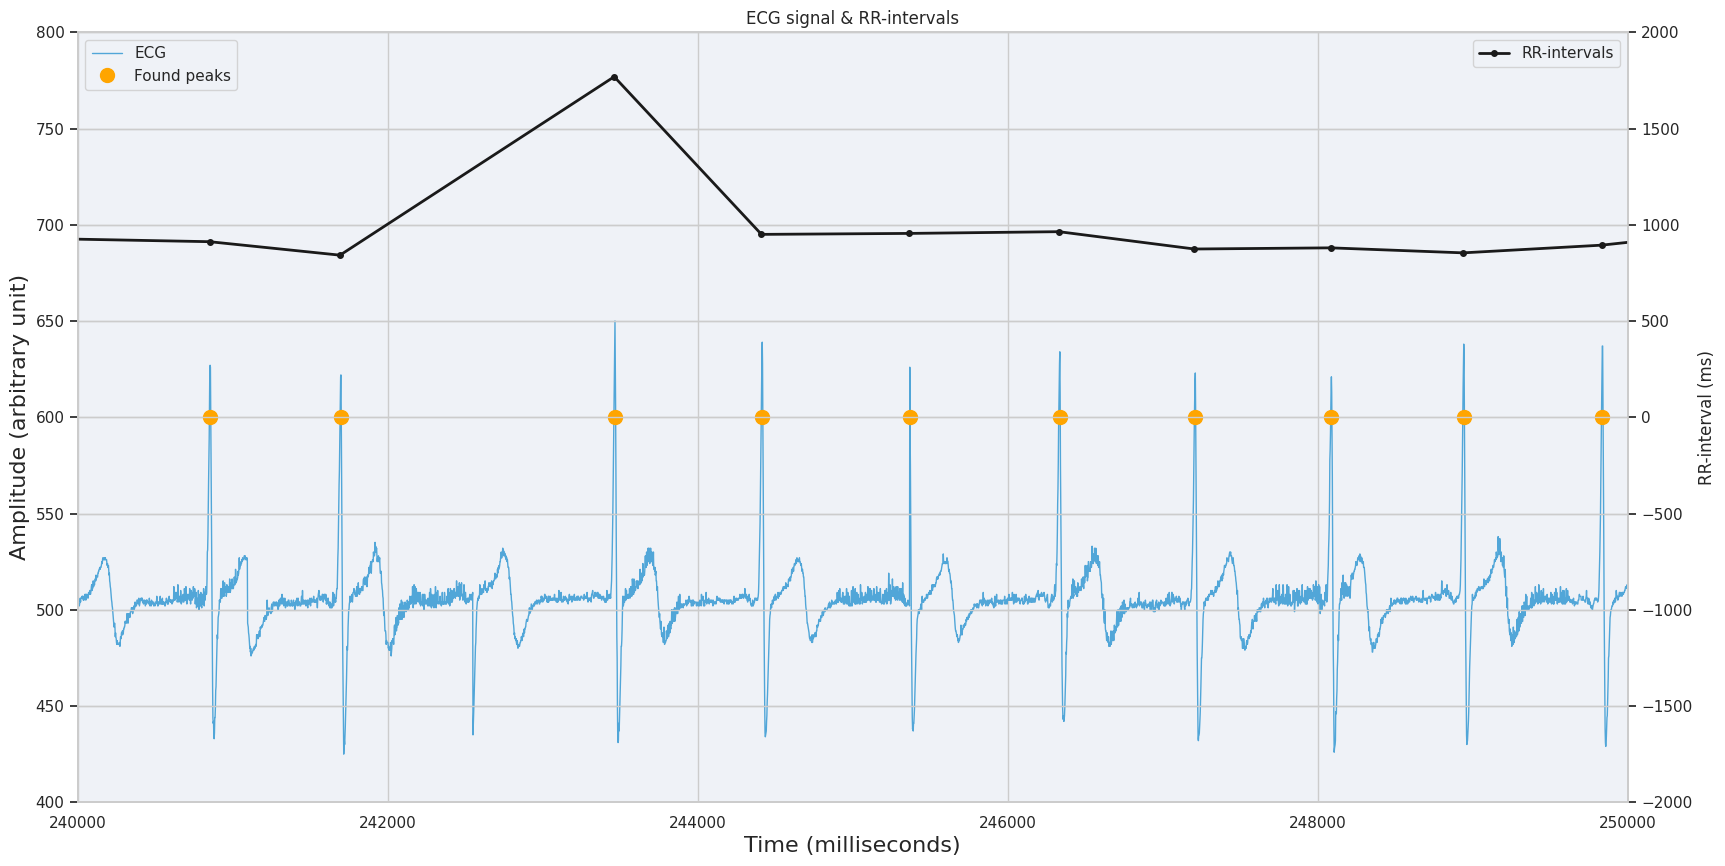

In [ ]:
sampfrom = 240000
sampto = 250000
nr_plots = 1

# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(20, 10))

    plt.title("ECG signal & RR-intervals")
    plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks, np.repeat(600, grouped_peaks.shape[0]), markersize=10, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left")
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(400, 800)
    
    ax2 = plt.gca().twinx()
    # ax2.plot(np.cumsum(rr_manual)+peaks[0], rr_manual, label="Corrected RR-intervals", fillstyle="none", color="#A651D8", markeredgewidth=1, marker="o", markersize=12)
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="k", linewidth=2, marker=".", markersize=8)
    
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right")
    plt.xlabel("Time (ms)")
    plt.ylabel("RR-interval (ms)")

In [ ]:
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [ ]:
print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(rr).items():
    print("- %s: %.2f" % (k, v))

print()

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 864.31
- STD RR/SDNN (ms): 114.49
- Mean HR (Kubios' style) (beats/min): 69.42
- Mean HR (beats/min): 77.11
- STD HR (beats/min): 100.24
- Min HR (beats/min): 33.92
- Max HR (beats/min): 1714.29
- RMSSD (ms): 147.30
- NNxx: 132.00
- pNNxx (%): 38.04



## Frequency domain analysis

Another approach for analysing heart rate variability is to study the power distribution in the frequency domain. It shows how much of signal lies within a certain frequency band. High (HF) frequencies between 0.15–0.40 Hz are associated with Parasympathetic activity (recovery) and lower frequencies (LF) between 0.04–0.15 Hz are linked to both sympathetic and parasympathetic activity. The ratio of LF/HF is believed to be a measure for the Autonomic Nervous System balance. A higher HF and a lower LF/HF ratio indicate an increased HRV, which means your body is recovering.

*Let’s get to it and do a frequency domain analysis on our data.*


In [ ]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

`Beginning Testing of Facial Expressions with corresponding real-time heart rates`

In [17]:
test_setheartRate = [20,87,69,120,130,67,30,48,86,57,28,118,103,49]
facial_emotionMaps = ['neutral', 'excited', 'tensed', 'sad']

`Loading test images for various samples`

In [ ]:
img = image.load_img("D:\My Work\Vikesh Heart Monitoring Major Project\test\excited\PrivateTest_139065.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

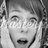

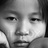

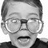

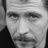

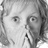

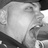

In [6]:
from IPython.display import display
from PIL import Image

display(Image.open(r'D:\My Work\Vikesh Heart Monitoring Major Project\test\excited\PrivateTest_139065.jpg'))
display(Image.open(r'D:\My Work\Vikesh Heart Monitoring Major Project\test\neutral\PrivateTest_1960069.jpg'))
display(Image.open(r'D:\My Work\Vikesh Heart Monitoring Major Project\test\tensed\PrivateTest_1850005.jpg'))
display(Image.open(r'D:\My Work\Vikesh Heart Monitoring Major Project\test\neutral\PrivateTest_2117908.jpg'))
display(Image.open(r'D:\My Work\Vikesh Heart Monitoring Major Project\test\excited\PrivateTest_20993679.jpg'))
display(Image.open(r'D:\My Work\Vikesh Heart Monitoring Major Project\test\tensed\PrivateTest_37308382.jpg'))

In [19]:
ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > bpm, test_image[n], threat

Facial expression for test image 1: tensed , bpm: 115. Threat = Yes, Recommend immediate dismissal from driving


In [20]:
ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > bpm, test_image[n], threat

Facial expression for test image 2: sad , bpm: 39. Threat = Yes, Recommend immediate dismissal from driving


In [25]:
ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > bpm, test_image[n], threat

Facial expression for test image 3: excited , bpm: 118. Threat = Yes, Recommend immediate dismissal from driving


In [27]:
ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > bpm, test_image[n], threat

Facial expression for test image 4: neutral , bpm: 87. Threat = Normal Heartrate


In [28]:
ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > bpm, test_image[n], threat

Facial expression for test image 5: tensed , bpm: 114. Threat = Yes, Recommend immediate dismissal from driving


In [29]:
ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > bpm, test_image[n], threat

Facial expression for test image 6: tensed , bpm: 127. Threat = Yes, Recommend immediate dismissal from driving
